<a href="https://colab.research.google.com/github/Befezdow/ai_test/blob/master/course_work%20(with_pca).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

drive.mount('/content/gdrive')
names_array = ['gender', 'age', 'class1', 'class2', 'class3', *['t{}'.format(i + 1) for i in range(60000)]]
url = '/content/gdrive/My Drive/ML/half.csv'
data = pd.read_csv(url, names=names_array)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Подготавливаем данные, заполняя пропущенные значения медианой.

In [2]:
data = data.fillna(data.median(axis = 0), axis = 0)
data

,gender,age,class1,class2,class3,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,...,t59961,t59962,t59963,t59964,t59965,t59966,t59967,t59968,t59969,t59970,t59971,t59972,t59973,t59974,t59975,t59976,t59977,t59978,t59979,t59980,t59981,t59982,t59983,t59984,t59985,t59986,t59987,t59988,t59989,t59990,t59991,t59992,t59993,t59994,t59995,t59996,t59997,t59998,t59999,t60000
0,Female,85,3,5.0,NaN,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,...,-0.026842,-0.028914,-0.028548,-0.029272,-0.031896,-0.036031,-0.039794,-0.033593,-0.028113,-0.031301,-0.041995,-0.045999,-0.043968,-0.039291,-0.030942,-0.031698,-0.030754,-0.033479,-0.033446,-0.036413,-0.038551,-0.035920,-0.036477,-0.036518,-0.041184,-0.039042,-0.033992,-0.033940,-0.031528,-0.026267,-0.028246,-0.028318,-0.025569,-0.021279,-0.018593,-0.032023,-0.046202,-0.042003,-0.034466,-0.039000
1,Male,79,9,5.0,NaN,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,...,-0.934049,-0.949376,-0.962051,-0.963686,-0.961742,-0.952030,-0.939060,-0.934415,-0.936366,-0.939326,-0.932011,-0.926725,-0.928331,-0.929013,-0.921389,-0.906309,-0.900787,-0.901273,-0.895911,-0.893740,-0.891627,-0.885869,-0.881577,-0.873489,-0.866113,-0.865862,-0.859139,-0.852907,-0.843380,-0.833925,-0.833698,-0.836701,-0.827418,-0.827810,-0.816231,-0.819793,-0.797862,-0.819597,-0.771195,-0.845490
2,Male,66,3,5.0,NaN,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,...,-0.051053,-0.052053,-0.051053,-0.049053,-0.047053,-0.044053,-0.040053,-0.037053,-0.036053,-0.034053,-0.034053,-0.034053,-0.033053,-0.031053,-0.028053,-0.025053,-0.022053,-0.019053,-0.017053,-0.017053,-0.016053,-0.016053,-0.014053,-0.013053,-0.010053,-0.007053,-0.003053,0.001947,0.004947,0.007947,0.009947,0.011947,0.012947,0.015947,0.018947,0.023947,0.027947,0.030947,0.034947,0.037947
3,Male,93,2,5.0,NaN,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,...,-0.117502,-0.208445,-0.254530,-0.270954,-0.254278,-0.223832,-0.205055,-0.179093,-0.157585,-0.127692,-0.089728,-0.074150,-0.056856,-0.038932,-0.024184,-0.016817,-0.014031,-0.011765,-0.022771,-0.023586,-0.013769,-0.004949,-0.003625,-0.013567,-0.019471,-0.015372,-0.021787,-0.028885,-0.028997,-0.021737,-0.013160,-0.006182,-0.003825,-0.002177,-0.001466,-0.006676,-0.011236,-0.016540,-0.016289,-0.022542
4,Male,65,2,5.0,NaN,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,...,1.016910,0.710028,0.406775,0.104651,-0.181270,-0.432753,-0.645005,-0.816434,-0.952654,-1.038151,-1.073172,-1.060904,-1.006902,-0.914312,-0.803500,-0.697

Осуществляем аугментацию данных. На каждый датчик идет по 5000 записей. Разбиваем так, чтобы на каждый приходилось по 100, тем самым размножая данные.

In [0]:
current_count_per_sensor = 5000
needed_count_per_sensor = 100
sensors_count = 12

non_sliceable_columns = data.iloc[:,0:5]
sliceable_columns = data.iloc[:,5:]

current_offset = 0
new_data = pd.DataFrame()
for i in range(int(np.floor(current_count_per_sensor / needed_count_per_sensor))):
  new_offset = current_offset + needed_count_per_sensor
  new_slice = pd.DataFrame()
  
  for j in range(sensors_count):
    index_from = j * current_count_per_sensor + current_offset
    index_to = j * current_count_per_sensor + new_offset
    data_slice = sliceable_columns.iloc[:, index_from:index_to]
    new_slice = pd.concat([new_slice, data_slice], axis=1, sort=False, ignore_index=True)
  
  completed_rows = pd.concat([non_sliceable_columns.copy(), new_slice], axis=1, sort=False, ignore_index=True)
  new_data = pd.concat([new_data, completed_rows], axis=0, sort=False, ignore_index=True)
  current_offset += needed_count_per_sensor

new_data.columns = ['gender', 'age', 'class1', 'class2', 'class3', *['t{}'.format(i + 1) for i in range(needed_count_per_sensor * sensors_count)]]

In [0]:
data = new_data

Выкидываем лишние классовые признаки, а затем осуществляем векторизацию и нормализацию данных.

In [5]:
# убираем лишние классовые признаки
data = data.drop('class2', axis = 1)
data = data.drop('class3', axis = 1)

#собираем числовые колонки
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object' and c != 'class1']

# векторизируем колонку gender
data.at[data['gender'] == 'Male', 'gender'] = 0
data.at[data['gender'] == 'Female', 'gender'] = 1

# нормализуем числовые атрибуты
data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data[numerical_columns] = data_numerical

data

,gender,age,class1,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37,...,t1161,t1162,t1163,t1164,t1165,t1166,t1167,t1168,t1169,t1170,t1171,t1172,t1173,t1174,t1175,t1176,t1177,t1178,t1179,t1180,t1181,t1182,t1183,t1184,t1185,t1186,t1187,t1188,t1189,t1190,t1191,t1192,t1193,t1194,t1195,t1196,t1197,t1198,t1199,t1200
0,1,1.177851,3,0.024810,0.089641,0.166249,0.079260,-0.183195,-0.239878,-0.229224,-0.311345,-0.353593,-0.276569,-0.194899,-0.124608,-0.107193,-0.176887,-0.201853,-0.266702,-0.334036,-0.375456,-0.389888,-0.385213,-0.248611,-0.170733,-0.265279,-0.231965,-0.162420,-0.280354,-0.328905,-0.320951,-0.306322,-0.279457,-0.310764,-0.396990,-0.447620,-0.450523,-0.453223,-0.495634,-0.503300,...,-0.281762,-0.281652,-0.282679,-0.280107,-0.265826,-0.244599,-0.226658,-0.234529,-0.236443,-0.258389,-0.269397,-0.244040,-0.233612,-0.233914,-0.240705,-0.260236,-0.264701,-0.214605,-0.232482,-0.247209,-0.285343,-0.309315,-0.304806,-0.269721,-0.277915,-0.276932,-0.274276,-0.224491,-0.258844,-0.260899,-0.258333,-0.254184,-0.247342,-0.230120,-0.231861,-0.225600,-0.247128,-0.245634,-0.256841,-0.266626
1,0,0.808696,9,0.089633,0.125414,0.117306,0.152087,0.150359,0.150870,0.149757,0.150433,0.151931,0.153868,0.192854,0.190815,0.116619,0.096582,0.095752,0.060556,0.039466,0.055681,0.060328,0.059317,0.059936,0.057892,0.059589,0.041363,-0.000022,-0.017737,-0.015379,-0.053639,-0.067829,-0.089579,-0.141626,-0.140784,-0.145060,-0.141832,-0.150440,-0.158980,-0.179465,...,1.277399,1.591452,1.949256,2.391251,2.901596,3.449840,3.954929,4.400384,4.779853,5.034665,5.030888,4.715864,4.194606,3.611433,3.115175,2.691228,2.311560,1.656903,1.643013,1.397020,1.215765,1.104194,1.042477,0.905557,0.931156,0.852095,0.756517,0.564518,0.604893,0.561188,0.533448,0.526664,0.530455,0.548706,0.558310,0.489712,0.516571,0.494300,0.479337,0.461718
2,0,0.008860,3,-0.068971,-0.061504,-0.069057,-0.062645,-0.056737,-0.049656,-0.049243,-0.048640,-0.040985,-0.048046,-0.040027,-0.032355,-0.025167,-0.032945,-0.032398,-0.032047,-0.039668,-0.032895,-0.025633,-0.032362,-0.025760,-0.019588,-0.006100,-0.014220,-0.008364,-0.008024,-0.013914,-0.014101,-0.014534,-0.007926,-0.001476,0.011986,0.032624,0.038989,0.046299,0.054910,0.056669,...,0.342476,0.363231,0.381090,0.392754,0.404233,0.416104,0.424317,0.434898,0.445092,0.451531,0.457970,0.458525,0.455772,0.455779,0.452729,0.447419,0.445639,0.374290,0.443081,0.440583,0.437367,0.431717,0.425354,0.380314,0.403103,0.394827,0.386485,0.321049,0.376301,0.371144,0.362767,0.356300,0.351041,0.339018,0.326720,0.289190,0.305516,0.292793,0.279864,0.265344
3,0,1.670058,2,-0.015739,0.031386,-0.014660,-0.043449,-0.036202,-0.061322,-0.144660,-0.262930,-0.273593,-0.184770,-0.168607,-0.259108,-0.315176,-0.221083,-0.163240,-0.075470,0.034093,0.143924,0.210039,0.123139,0.032848,0.017904,0.098192,0.109136,0.009856,-0.022685,-0.002609,-0.001402,0.079040,0.157510,0.198223,0.206091,0.210890,0.244174,0.359667,0.420744,0.257516,...,-0.082333,-0.057747,-0.029369,-0.023311,-0.013463,-0.002650,-0.002732,-0.000867,-0.001111,-0.000607,-0.000472,-0.000599,0.000362,-0.000267,0.006970,0.010258,0.009969,-0.007767,-0.012269,-0.002452,-0.011535,-0.012707,-0.014890,-0.022144,-0.022074,-0.023712,-0.016937,-0.016193,-0.039933,-0.058460,-0.060961,-0.055542,-0.052412,-0.052737,-0.033069,-0.017898,-0.034528,-0.032431,-0.049405,-0.045061
4,0,-0.052666,2,-0.224116,-0.200036,-0.101375,-0.173736,-0.180879,-0.263988,-0.253109,-0.100358,-0.070424,-0.163826,-0.240091,-0.236738,-0.131612,-0.125774,-0.220814,-0.235917,-0.073979,0.036815,0.046850,-0.017050,-0.040342,-0.039913,-0.061496,0.012219,0.049496,0.014800,-0.000405,-0.058276,-0.124513,-0.074536,-0.007725,-0.091796,-0.062091,-0.024787,-0.044343,0.028531,-0.055587,...,-0.049339,-0.049629,-0.048969,-0.048647,-0.047396,-0.047525,-0.037144,-0.019713,-0.018608,-0.016827,-0.002320,-0.006999,-0.009981,-0.007894,-0.010623,-0.022330,-0.025839,-0.029534,-0.030805,-0.02

Разбиваем данные на входы и выходы.

In [0]:
# бьем данные на входы и выходы
x = data.drop('class1', axis = 1)
y = data['class1']

Разбиваем данные на обучающую и тестовую выборки.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

n_train, _ = x_train.shape 
n_test,  _ = x_test.shape 

print('Train dataset size: {}'.format(n_train))
print('Test dataset size: {}'.format(n_test))

Train dataset size: 43750
Test dataset size: 18750


In [0]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Заворачиваем данные в тензоры. Это необходимо для pytorch.

In [9]:
import torch

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).long() - 1

x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test).long() - 1

print('Train X shape: {}'.format(x_train.shape))
print('Train Y shape: {}'.format(y_train.shape))

print('Test X shape: {}'.format(x_test.shape))
print('Test Y shape: {}'.format(y_test.shape))

Train X shape: torch.Size([43750, 1202])
Train Y shape: torch.Size([43750])
Test X shape: torch.Size([18750, 1202])
Test Y shape: torch.Size([18750])


Инициализируем нейронную сеть. Она будет иметь 2 внутренних слоя по 500 нейронов. В качестве логистической функции используем relu на внутренних слоях, на выходах - softmax. 
Оптимизатор: Adam (до этого использовал SGD, но не заметил кардинальной разницы). 
Функция потерь - NLLLoss.
Количество эпох: 10.
Размер одного батча данных: 100.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(1202, 500)
    self.fc2 = nn.Linear(500, 500)
    self.fc3 = nn.Linear(500, 9)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

net = Net().double()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.NLLLoss()

epochs_count = 10
batch_size = 100

dataset_size = x_train.shape[0]
batches_count = int(np.ceil(dataset_size / batch_size))

for epoch_index in range(epochs_count):
  for batch_index in range(batches_count):
    x_var = Variable(x_train[batch_index * batch_size:batch_index * batch_size + batch_size])
    y_var = Variable(y_train[batch_index * batch_size:batch_index * batch_size + batch_size])

    optimizer.zero_grad()
    net_out = net(x_var.double())
    loss = criterion(net_out, y_var)
    loss.backward()
    optimizer.step()
    
    # print('Train Epoch: {}; Batch: {}/{}; tLoss: {:.6f}'.format(epoch_index + 1, batch_index + 1, batches_count, loss.data.item()))


Прогоняем тестовые данные:

In [11]:
dataset_size = x_test.shape[0]

batch_size = 100
batches_count = int(np.ceil(dataset_size / batch_size))

test_loss = 0
correct = 0
for batch_index in range(batches_count):
    x_var = Variable(x_test[batch_index * batch_size:batch_index * batch_size + batch_size])
    y_var = Variable(y_test[batch_index * batch_size:batch_index * batch_size + batch_size])

    net_out = net(x_var.double())
    test_loss += criterion(net_out, y_var).item()  # суммируем потери со всех партий
    pred = net_out.data.max(1)[1]  # получаем индекс максимального значения
    correct += pred.eq(y_var.data).sum()

test_loss /= dataset_size
print('Average loss: {:.4f}; Accuracy: {}/{} ({:.2f}%)'.format(
    test_loss, correct, dataset_size, 100. * correct / dataset_size
))

Average loss: 0.0151; Accuracy: 9549/18750 (50.93%)


Получаем точность приблизительно в 51 процент.

Попробуем различное количество компонент и сравним ошибки (от 50 до 500 с интервалом в 50). Исходя из предыдущих опытов, было получено, что наилучшие результаты получается при 500 нодах во внутренних слоях с параметром weight_decay, равным 1e-4.

In [17]:
from sklearn import decomposition

train_error_list = []
test_error_list = []
components_count_list = []

for components_count in np.arange(50, 550, 50):
  print('Components count: {}'.format(components_count))
  pca = decomposition.PCA(n_components=components_count)
  principal_components = pca.fit_transform(x)
  principal_x = pd.DataFrame(
      data = principal_components, 
      columns = ['pc{}'.format(i + 1) for i in range(components_count)]
  )
  principal_x

  x_train, x_test, y_train, y_test = train_test_split(principal_x, y, test_size = 0.3, random_state = 42)

  x_train = x_train.to_numpy()
  x_test = x_test.to_numpy()
  y_train = y_train.to_numpy()
  y_test = y_test.to_numpy()

  x_train = torch.Tensor(x_train)
  y_train = torch.Tensor(y_train).long() - 1

  x_test = torch.Tensor(x_test)
  y_test = torch.Tensor(y_test).long() - 1

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(components_count, 500)
      self.fc2 = nn.Linear(500, 500)
      self.fc3 = nn.Linear(500, 9)
    
    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x, dim=1)

  net = Net().double()

  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay = 1e-4)
  criterion = nn.NLLLoss()

  epochs_count = 10
  batch_size = 100

  dataset_size = x_test.shape[0]
  batches_count = int(np.ceil(dataset_size / batch_size))

  for epoch_index in range(epochs_count):
    train_loss = 0
    correct = 0
    for batch_index in range(batches_count):
      x_var = Variable(x_train[batch_index * batch_size:batch_index * batch_size + batch_size])
      y_var = Variable(y_train[batch_index * batch_size:batch_index * batch_size + batch_size])

      optimizer.zero_grad()
      net_out = net(x_var.double())
      loss = criterion(net_out, y_var)

      train_loss += loss.item()
      pred = net_out.data.max(1)[1]  # получаем индекс максимального значения
      correct += pred.eq(y_var.data).sum()

      loss.backward()
      optimizer.step()

  train_loss /= dataset_size
  train_percentage = 100. * correct.item() / dataset_size
  print('Train :: Average loss: {:.4f}; Accuracy: {}/{} ({:.2f}%)'.format(train_loss, correct, dataset_size, train_percentage))


  dataset_size = x_test.shape[0]
  batch_size = 100
  batches_count = int(np.ceil(dataset_size / batch_size))

  test_loss = 0
  correct = 0
  for batch_index in range(batches_count):
      x_var = Variable(x_test[batch_index * batch_size:batch_index * batch_size + batch_size])
      y_var = Variable(y_test[batch_index * batch_size:batch_index * batch_size + batch_size])

      net_out = net(x_var.double())
      test_loss += criterion(net_out, y_var).item()  # суммируем потери со всех партий
      pred = net_out.data.max(1)[1]  # получаем индекс максимального значения
      correct += pred.eq(y_var.data).sum()

  test_loss /= dataset_size
  test_percentage = 100. * correct.item() / dataset_size
  print('Test :: Average loss: {:.4f}; Accuracy: {}/{} ({:.2f}%)'.format(
      test_loss, correct, dataset_size, test_percentage
  ))

  train_error_list.append(100 - train_percentage)
  test_error_list.append(100 - test_percentage)
  components_count_list.append(components_count)

Components count: 50
Train :: Average loss: 0.0116; Accuracy: 11207/18750 (59.77%)
Test :: Average loss: 0.0174; Accuracy: 8512/18750 (45.40%)
Components count: 100
Train :: Average loss: 0.0099; Accuracy: 12375/18750 (66.00%)
Test :: Average loss: 0.0187; Accuracy: 8739/18750 (46.61%)
Components count: 150
Train :: Average loss: 0.0092; Accuracy: 12858/18750 (68.58%)
Test :: Average loss: 0.0188; Accuracy: 8953/18750 (47.75%)
Components count: 200
Train :: Average loss: 0.0087; Accuracy: 13223/18750 (70.52%)
Test :: Average loss: 0.0198; Accuracy: 8684/18750 (46.31%)
Components count: 250
Train :: Average loss: 0.0082; Accuracy: 13558/18750 (72.31%)
Test :: Average loss: 0.0201; Accuracy: 8729/18750 (46.55%)
Components count: 300
Train :: Average loss: 0.0081; Accuracy: 13673/18750 (72.92%)
Test :: Average loss: 0.0211; Accuracy: 8693/18750 (46.36%)
Components count: 350
Train :: Average loss: 0.0079; Accuracy: 13827/18750 (73.74%)
Test :: Average loss: 0.0209; Accuracy: 8621/18750 (4

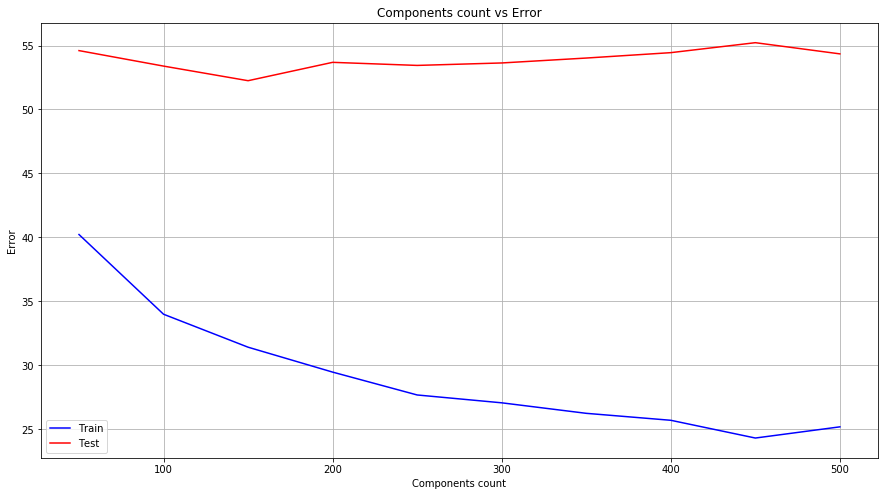

In [20]:
plt.figure(figsize = (15, 8))
plt.plot(components_count_list, train_error_list, label = 'Train', color = 'blue')
plt.plot(components_count_list, test_error_list, label = 'Test', color = 'red')

plt.xlabel('Components count')
plt.ylabel('Error')
plt.title('Components count vs Error')
plt.legend()
plt.grid()

Видим, что на тренировочных данных ошибка падает с увеличением числа компонент. Однако на на тестовой выборке накого тренда не наблюдается. Наилучшая точность на тестовой выборке достигается при 150 компонентах и составляет 47.75%. Заметим, что точность упала незначительно (примерно на 3%), однако количество входных компонент сократилось почти в 10 раз.